In [6]:
import sys
import os

# Add the path to 'src' to Python's module search path
project_root = os.path.abspath('../src')
if project_root not in sys.path:
    sys.path.append(project_root)

# Now you can import your model
from KoopmanIsentropicVAE.model import VAE


In [7]:
import numpy as np
import random
import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.nn.utils import clip_grad_norm_
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import pickle

# ========== SETUP SEED & DEVICE ==========
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

device = torch.device("mps" if torch.backends.mps.is_available() else
                      "cuda" if torch.cuda.is_available() else "cpu")


In [8]:
import numpy as np
path_reshape = '/Volumes/LaCie/000_POSTDOC_2025/long_high_res/reshaped_rho_w_sum.npy'
data_isentropic = np.load(path_reshape)

import numpy as np
path_pw = '/Volumes/LaCie/000_POSTDOC_2025/long_high_res/var_pw.npy'
data_evolution_pw = np.load(path_pw)

data_evolution_pw.shape[0] == data_isentropic.shape[0]

valid_indices_path = '/Volumes/LaCie/000_POSTDOC_2025/long_high_res/valid_indices.npy'
valid_indices = np.load(valid_indices_path)

In [9]:
import torch
import pySAMetrics

# ========== LOAD DATA ==========
data_path = '/Volumes/LaCie/000_POSTDOC_2025/long_high_res/smoothed_masked_log.npy'
data = np.load(data_path)
input_dim = data.shape[1]

# ========== MODEL & OPTIMIZER ==========
latent_dim = 8
model = VAE(input_dim=input_dim, hidden_dim=512, latent_dim=latent_dim).to(device)

# Step 2: Load the saved weights
model_path = "/Volumes/LaCie/000_POSTDOC_2025/long_high_res/koopman_vae_model.pt"
model.load_state_dict(torch.load(model_path, map_location=torch.device('cpu')))  # or 'cuda' if you use GPU

# Step 3: Set the model to evaluation mode if you're going to use it for inference
model.eval()

print("✅ Model loaded successfully.")


✅ Model loaded successfully.


/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_94138/3752320066.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path,

In [10]:
# ========== DATA SPLITS ==========
n_total = len(data)
train_end = int(0.95 * n_total)
val_end = train_end + int(0.025 * n_total)

train_tensor = torch.tensor(data[:train_end], dtype=torch.float32)
val_tensor = torch.tensor(data[train_end:val_end], dtype=torch.float32)
test_tensor = torch.tensor(data[val_end:], dtype=torch.float32)

steps = [1, 3, 5, 10, 15]
# ========== DATASET CLASS ==========
class MultiStepTemporalDataset(Dataset):
    def __init__(self, data, steps):
        self.data = data
        self.steps = steps
        self.max_step = max(steps)

    def __len__(self):
        return len(self.data) - self.max_step

    def __getitem__(self, idx):
        x_t = self.data[idx]
        x_future = [self.data[idx + s] for s in self.steps]
        return x_t, torch.stack(x_future)


train_loader = DataLoader(MultiStepTemporalDataset(train_tensor, steps), batch_size=128, shuffle=True)
val_loader = DataLoader(MultiStepTemporalDataset(val_tensor, steps), batch_size=128)
test_loader = DataLoader(MultiStepTemporalDataset(test_tensor, steps), batch_size=128)


In [11]:
def create_image_from_flat_tensor(x):
    images = np.zeros((x.shape[0], 48*48))
    images[:, valid_indices] = x
    images = images.reshape(-1, 48, 48)
    return images

In [12]:
model.eval()

val_latent_reprs = []
val_reconstructed_imgs = []
val_original_imgs = []
#val_indices = []

for i_val, val_originals in enumerate(val_loader):
    val_originals = val_originals[0]
    val_original_imgs.append(val_originals)
    val_originals = val_originals.to(device)  # shape: [B, 1, 48, 48]

    with torch.no_grad():
        val_reconstructions, mu , _ = model(val_originals)

    val_latent_reprs.append(mu.detach().cpu())
    val_reconstructed_imgs.append(val_reconstructions.detach().cpu())
    #val_indices.append(range(i_val*batch_size, (1+i_val)*batch_size))

val_latent_reprs = np.concatenate(val_latent_reprs)
val_reconstructed_imgs = np.concatenate(val_reconstructed_imgs)
val_original_imgs = np.concatenate(val_original_imgs)
#val_indices = np.concatenate(val_indices)
val_original_imgs.shape, val_reconstructed_imgs.shape, val_latent_reprs.shape

((471, 1560), (471, 1560), (471, 8))

In [13]:
# Convert to PyTorch tensors
full_tensor = torch.tensor(data, dtype=torch.float32)
full_loader = DataLoader(full_tensor, batch_size=128, shuffle=False)

In [14]:
model.eval()

full_latent_reprs = []
full_reconstructed_imgs = []
full_original_imgs = []

for i_val, full_originals in enumerate(full_loader):
    full_original_imgs.append(full_originals)
    full_originals = full_originals.to(device)  # shape: [B, 1, 48, 48]

    with torch.no_grad():
        full_reconstructions, mu , _ = model(full_originals)

    full_latent_reprs.append(mu.detach().cpu())
    full_reconstructed_imgs.append(full_reconstructions.detach().cpu())
    #val_indices.append(range(i_val*batch_size, (1+i_val)*batch_size))

full_latent_reprs = np.concatenate(full_latent_reprs)
full_reconstructed_imgs = np.concatenate(full_reconstructed_imgs)
full_original_imgs = np.concatenate(full_original_imgs)
#val_indices = np.concatenate(val_indices)
full_original_imgs.shape, full_reconstructed_imgs.shape, full_latent_reprs.shape

((19476, 1560), (19476, 1560), (19476, 8))

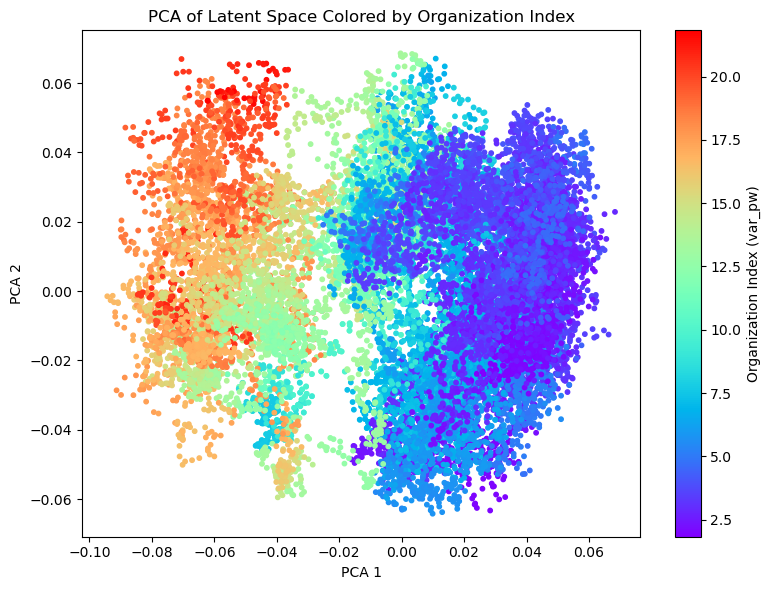

In [15]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Choose which method to use: PCA or t-SNE
use_tsne = False  # Set to True for t-SNE, False for PCA

if use_tsne:
    reducer = TSNE(n_components=2, random_state=42, perplexity=100)
    latent_2d = reducer.fit_transform(full_latent_reprs)
    method = "t-SNE"
else:
    reducer = PCA(n_components=2)
    latent_2d = reducer.fit_transform(full_latent_reprs)
    method = "PCA"

# Scatter plot, colored by organization index
plt.figure(figsize=(8, 6))
sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c=data_evolution_pw, cmap='rainbow', s=10)
plt.colorbar(sc, label='Organization Index (var_pw)')
plt.xlabel(f'{method} 1')
plt.ylabel(f'{method} 2')
plt.title(f'{method} of Latent Space Colored by Organization Index')
plt.tight_layout()
plt.show()

/var/folders/1g/zpcrn7ys4y15p92_t65w5_200000gn/T/ipykernel_94138/4138103140.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='tab:blue', cmap='rainbow', s=10)


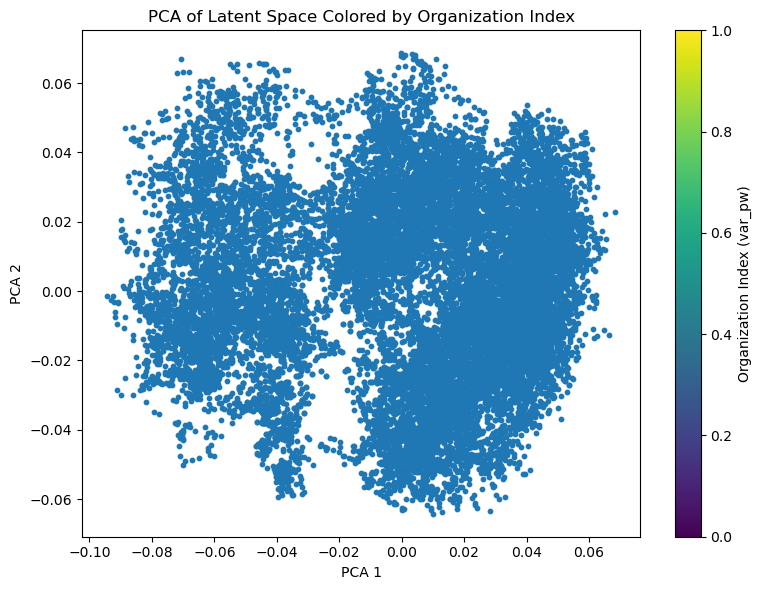

In [16]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Choose which method to use: PCA or t-SNE
use_tsne = False  # Set to True for t-SNE, False for PCA

if use_tsne:
    reducer = TSNE(n_components=2, random_state=42, perplexity=100)
    latent_2d = reducer.fit_transform(full_latent_reprs)
    method = "t-SNE"
else:
    reducer = PCA(n_components=2)
    latent_2d = reducer.fit_transform(full_latent_reprs)
    method = "PCA"

# Scatter plot, colored by organization index
plt.figure(figsize=(8, 6))
sc = plt.scatter(latent_2d[:, 0], latent_2d[:, 1], c='tab:blue', cmap='rainbow', s=10)
plt.colorbar(sc, label='Organization Index (var_pw)')
plt.xlabel(f'{method} 1')
plt.ylabel(f'{method} 2')
plt.title(f'{method} of Latent Space Colored by Organization Index')
plt.tight_layout()
plt.show()

In [15]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np

# If not already, make sure latent_2d is a numpy array
latent_2d = np.array(latent_2d)
ntime = latent_2d.shape[0]

fig, ax = plt.subplots(figsize=(8, 6))
scat = ax.scatter([], [], s=20, color='blue')
ax.set_xlim(np.min(latent_2d[:, 0]), np.max(latent_2d[:, 0]))
ax.set_ylim(np.min(latent_2d[:, 1]), np.max(latent_2d[:, 1]))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Animation: Dots Appearing in Time')

def update(frame):
    scat.set_offsets(latent_2d[:frame+1])
    return scat,

ani = FuncAnimation(fig, update, frames=ntime, interval=10, blit=True)

# Save as mp4 (requires ffmpeg installed)
writer = FFMpegWriter(fps=60, bitrate=1800)
ani.save('pca_animation.mp4', writer=writer)
plt.close(fig)
print("Animation saved as pca_animation.mp4")

Animation saved as pca_animation.mp4


In [14]:
step = 10  # Show every 10th point
latent_2d_sub = latent_2d[::step]
data_evolution_pw_sub = data_evolution_pw[::step]
ntime_sub = latent_2d_sub.shape[0]

In [16]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation, FFMpegWriter
import numpy as np

step = 4  # Change as needed
latent_2d_sub = latent_2d[::step]
data_evolution_pw_sub = data_evolution_pw[::step]
ntime_sub = latent_2d_sub.shape[0]

fig, ax = plt.subplots(figsize=(8, 6))
scat = ax.scatter([], [], s=20, c=[], cmap='rainbow', vmin=2.5, vmax=20)
ax.set_xlim(np.min(latent_2d[:, 0]), np.max(latent_2d[:, 0]))
ax.set_ylim(np.min(latent_2d[:, 1]), np.max(latent_2d[:, 1]))
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_title('PCA Animation: Dots Appearing in Time')

norm = plt.Normalize(2.5, 20)
sm = plt.cm.ScalarMappable(cmap='rainbow', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=ax)
cbar.set_label('data_evolution_pw')

def update(frame):
    scat.set_offsets(latent_2d_sub[:frame+1])
    scat.set_array(data_evolution_pw_sub[:frame+1])
    return scat,

ani = FuncAnimation(fig, update, frames=ntime_sub, interval=10, blit=True)

writer = FFMpegWriter(fps=60, bitrate=1800)
ani.save('pca_animation_colored_pw_subsampled.mp4', writer=writer)
plt.close(fig)
print("Animation saved as pca_animation_colored_pw_subsampled.mp4")

Animation saved as pca_animation_colored_pw_subsampled.mp4


In [5]:
import os
import shutil
from natsort import natsorted

In [6]:
sorted_dir = '/Volumes/LaCie/000_POSTDOC_2025/long_high_res/sorted_dir'
image_dir = '/Volumes/LaCie/000_POSTDOC_2025/long_high_res/video_img_long_june'

os.makedirs(sorted_dir, exist_ok=True)

# --- 2. SORT IMAGES NATURALLY ---
all_images = [f for f in os.listdir(image_dir) if f.endswith('.png')]
all_images = natsorted(all_images)

In [10]:
# --- 3. COPY & RENAME ---
for i, fname in enumerate(all_images):
    src = os.path.join(image_dir, fname)
    dst = os.path.join(sorted_dir, f"img_{i:06d}.png")
    shutil.copy(src, dst)

print(f"Copied and renamed {len(all_images)} images to {sorted_dir}")

Copied and renamed 5462 images to /Volumes/LaCie/000_POSTDOC_2025/long_high_res/sorted_dir
